# Main modelling script

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

from lib.formatter import *
from lib.conversions import *
from lib.detector_modelling import *
from lib.FT_modelling import *
from lib.synphot import *

To Do:
- Explore the distortions in the PSFs generated when modelling off-axis stars with Fourier Transforms
- Bayer interpolation

## Set simulation parameters

In [29]:
simulation = "Tinytol"
# simulation = "Toliman"

num_positions = 60

In [30]:
if simulation == "Tinytol":
    # Optical Architecture
    aperture = 0.02 # m
    central_obscuration = 0 # m, diameter
    focal_length = 0.15 # m
    
    # CCD Architecture
#     detector_size = 2048
    detector_size = 256
    detector_pitch = 1.12e-6
    fps = 10
    
    # Actual values need to be set
    QE = 0.9
    read_noise = 1.6
    dark_current = 0.68
    gain = 1.29
    full_well = 95e3
    
elif simulation == "Toliman":
    # Optical Architecture
    aperture = 0.1 # m
    central_obscuration = 0.0175 # m, diameter
    focal_length = 3.85 # m
    
    # CCD Architecture
    detector_size = 2000
    detector_pitch = 7e-6
    fps = 7.5
    QE = 0.9
    read_noise = 1.6
    dark_current = 0.68
    gain = 1.29
    full_well = 95e3
    
else:
    print("Set simulation settings to either \"Toliman\" or \"Tinytol\"")

## Create sterllar objects

In [31]:
# Inputs for pysynphot
nwavels = 1001
wl_range = np.array([445e-9, 545e-9]) # Angstroms

In [32]:
# Stellar Parameters
acenA = {"mag":0.01, 
        "Teff":5790, 
        "Z": 0.2, 
        "log g": 4.30}

acenB = {"mag":1.33, 
        "Teff":5260, 
        "Z": 0.23, 
        "log g": 4.37}

In [33]:
# Create stellar observation object
acenA["obs"] = create_stellar_obs(aperture*100, central_obscuration*100, nwavels, wl_range*(10e9), acenA)
acenB["obs"] = create_stellar_obs(aperture*100, central_obscuration*100, nwavels, wl_range*(10e9), acenB)

# Uncomment this to get equal magnitudes (makes it easier to distinguish)
# acenB["obs"] = create_stellar_obs(aperture, central_obscuration, nwavels, wl_range, acenA)

# Calculate photon rate per second
acenA["rate/s"] = acenA["obs"].countrate() # Has units of counts per second
acenB["rate/s"] = acenB["obs"].countrate() # Has units of counts per second

# Caluate photon rate per frame
acenA["rate/frame"] = acenA["rate/s"]/fps
acenB["rate/frame"] = acenB["rate/s"]/fps

# Calculate the offset
acenA["coord"] = SkyCoord("14h39m36.49400s -60d50m02.3737s")
acenB["coord"] = SkyCoord("14h39m35.06311s -60d50m15.0992s")
azimuthal_offset = acenA["coord"].separation(acenB["coord"]).arcsec

## PSF modelling with Fourier Transforms

To Do:
- Sample the spectra from pysynphot to create broadbrand simulations (computationally heavy)

In [34]:
pupil = pupil_from_fits("files/pupil_new_2k.fits")
wavelength  = 500e-9

In [35]:
%%time
# Create on axis psf for alpha cen A
psf_on = model_FT(pupil, aperture, detector_size, wavelength, focal_length, detector_pitch)
psf_on = acenA["rate/frame"] * psf_on / np.sum(psf_on)

CPU times: user 3.43 s, sys: 688 ms, total: 4.12 s
Wall time: 2.27 s


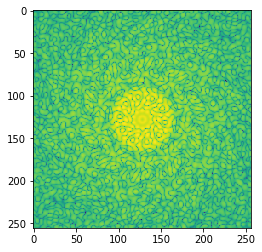

In [36]:
plt.imshow(np.log(psf_on))

In [37]:
%%time
detector_psfs = []
pupils = []
for angular_offset in np.linspace(-np.pi, np.pi, num=num_positions):
    off_axis_pupil = pupil_phase_offset(pupil, aperture, wavelength, azimuthal_offset, angular_offset)
    pupils.append(off_axis_pupil)
    psf_off = model_FT(off_axis_pupil, aperture, detector_size, wavelength, focal_length, detector_pitch)
    psf_off = acenB["rate/frame"] * psf_off / np.sum(psf_off)
#     detector_psfs.append(psf_on + psf_off)
    detector_psfs.append(np.log(psf_off))

CPU times: user 4min 21s, sys: 49.1 s, total: 5min 10s
Wall time: 2min 54s


## PSF modelling with Zemax

In [7]:
#Input the raw the psf from zemax
psf_on, psf_on_meta_data = zemax_to_array('files/Toliman_on-axis_broadband.txt')
psf_off, psf_off_meta_data = zemax_to_array('files/Toliman_off-axis_broadband.txt')

# Normalise the zemax psfs to photon count per frame
acenA["psf_norm"] = acenA["rate/frame"] * psf_on / np.sum(psf_on)
acenB["psf_norm"] = acenB["rate/frame"] * psf_off / np.sum(psf_off)

zemax_pixel_size = 1.75e-6

In [9]:
%%time
detector_psfs = interpolate_to_detector([acenA["psf_norm"], acenA["psf_norm"]], azimuthal_offset,\
                                        zemax_pixel_size, detector_pitch, focal_length, num_positions)

CPU times: user 10.9 s, sys: 326 ms, total: 11.2 s
Wall time: 10.1 s


## Add detector noise

In [30]:
images = []
for psf in detector_psfs:
    im = CCD_output(psf, QE, read_noise, dark_current, fps, gain, full_well)
    images.append(im)
    
    # Build Bayer interpolation for tinytol (it exists somewhere in old_repo)
#     if simulation == "Tinytol":
#         im = Bayer_interpolate()

## Create a gif from the series of simulated images

In [25]:
create_gif(detector_psfs, "distortion_test")

In [ ]:
inv = np.fft.ifft2(detector_psfs[0])
plt.imshow(np.angle(inv))